In [1]:
import time
import os
import numba

from coffea.nanoevents import BaseSchema
 
import awkward as ak
import numpy as np
from coffea import processor, hist

from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

import mplhep
import matplotlib.pyplot as plt
plt.style.use(mplhep.style.CMS)

In [2]:
muon_cols = ['Muon_charge', 'Muon_dxy', 'Muon_dxyErr', 'Muon_dz', 'Muon_dzErr', 'Muon_eta', 'Muon_isGlobal', 'Muon_mass',
             'Muon_phi', 'Muon_pt', 'Muon_ptErr', 'Muon_softId', 'Muon_vtxIdx', 'Muon_vtxFlag', 'Muon_simIdx']

dimu_cols = ['Dimu_pt', 'Dimu_eta', 'Dimu_phi', 'Dimu_rap', 'Dimu_mass', 'Dimu_charge', 'Dimu_vtxIdx', 'Dimu_chi2', 'Dimu_dl',
             'Dimu_dlErr', 'Dimu_dlSig', 'Dimu_cosphi', 'Dimu_x', 'Dimu_y', 'Dimu_z', 'Dimu_t1muIdx', 'Dimu_t2muIdx',]

d0_cols = ['D0_pt', 'D0_eta', 'D0_phi', 'D0_rap', 'D0_mass12', 'D0_mass21', 'D0_vtxIdx', 'D0_chi2', 'D0_dl', 'D0_dlErr', 'D0_dlSig',
           'D0_cosphi', 'D0_x', 'D0_y', 'D0_z', 'D0_hasMuon',
           'D0_t1pt', 'D0_t1eta', 'D0_t1phi', 'D0_t1chindof', 'D0_t1nValid', 'D0_t1nPix', 'D0_t1dxy', 'D0_t1dz', 'D0_t1chg', 
           'D0_t2pt', 'D0_t2eta', 'D0_t2phi', 'D0_t2chindof', 'D0_t2nValid', 'D0_t2nPix', 'D0_t2dxy', 'D0_t2dz', 'D0_t2chg',]

dstar_cols = ['Dstar_pt', 'Dstar_eta', 'Dstar_phi', 'Dstar_rap', 'Dstar_deltam', 'Dstar_deltamr', 'Dstar_vtxIdx', 'Dstar_hasMuon',
              'Dstar_D0pt', 'Dstar_D0eta', 'Dstar_D0phi', 'Dstar_D0mass', 'Dstar_D0chi2', 'Dstar_D0dl', 'Dstar_D0dlErr',
              'Dstar_D0dlSig', 'Dstar_D0cosphi', 'Dstar_D0x', 'Dstar_D0y', 'Dstar_D0z',
              'Dstar_Kpt', 'Dstar_Keta', 'Dstar_Kphi', 'Dstar_KvtxIdx', 'Dstar_Kchindof', 'Dstar_KnValid', 'Dstar_KnPix', 'Dstar_Kdxy',
              'Dstar_Kdz', 'Dstar_Kchg',
              'Dstar_pipt', 'Dstar_pieta', 'Dstar_piphi', 'Dstar_pivtxIdx', 'Dstar_pichindof', 'Dstar_pinValid', 'Dstar_pinPix',
              'Dstar_pidxy', 'Dstar_pidz', 'Dstar_pichg',
              'Dstar_pispt', 'Dstar_piseta', 'Dstar_pisphi', 'Dstar_pisvtxIdx', 'Dstar_pischindof', 'Dstar_pisnValid', 'Dstar_pisnPix',
              'Dstar_pisdxy', 'Dstar_pisdz', 'Dstar_simIdx', 'Dstar_D0simIdx']

gen_part_cols = ['GenPart_eta', 'GenPart_genPartIdxMother', 'GenPart_mass', 'GenPart_pdgId', "GenPart_phi", "GenPart_pt", 'GenPart_status',
                'GenPart_Id', 'GenPart_parpdgId', 'GenPart_sparpdgId', 'GenPart_numberOfDaughters', 'GenPart_nstchgdaug', 'GenPart_vx', 
                'GenPart_vy', 'GenPart_vz', 'GenPart_mvx', 'GenPart_mvy', 'GenPart_mvz', 'GenPart_recIdx']

D0_PDG_MASS = 1.864

def get_vars_dict(events, col_list):
    dict = {}
    col = ''
    for c in col_list:
        if c.startswith('Muon'):
            col = c[5:]
        elif c.startswith('Dimu'):
            col = c[4:]
            if col.startswith('_'): col = col[1:]
        elif c.startswith('D0'):
            col = c[2:]
            if col.startswith('_'): col = col[1:]
        elif c.startswith('Dstar'):
            col = c[5:]
            if col.startswith('_'): col = col[1:]
        elif c.startswith('PVtx'):
            col = c[5:]
        elif c.startswith("GenPart"):
            col = c[8:]
        else:
            Exception('Not good!')

        if col == 'x' or col == 'y' or col == 'z':
            col = 'vtx_' + col

        if len(events[c]) == 0:
            dict[col] = np.array([])
        else:
            dict[col] = events[c]
    return dict

In [3]:
import re

files = []
with os.scandir("/eos/user/m/mabarros/Monte_Carlo/2017/0000") as it:
    for file in it:
        if file.name.endswith('.root') and (file.stat().st_size != 0):
            files.append(file.path)

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]
            
files.sort(key=natural_keys)

In [4]:
def ratio_plot(hist_reco, hist_mc):
    fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
    }
    error_opts_1 = {
        'facecolor': 'none',
        'edgecolor': (0,0,0,.5),
        'linewidth': 0
    }
    data_err_opts = {
        'linestyle': 'none',
        'marker': '.',
        'markersize': 10.,
        'color': 'k',
        'elinewidth': 1,
    }
    
    error_opts_2 = {
        'facecolor': 'none',
        'linewidth': 0,
    }
    
    fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10,10),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
    )
    fig.subplots_adjust(hspace=.07)
    
    # plot the MC first
    hist.plot1d(
        hist_mc,
        ax=ax,
        clear=False,
        stack=False,
        line_opts=None,
        fill_opts=fill_opts,
        error_opts=error_opts_1
    )
    hist.plot1d(
        hist_reco,
        ax=ax,
        clear=False,
        stack=False,
        line_opts=None,
        fill_opts=fill_opts,
        error_opts=error_opts_2
    )
    
    ax.autoscale(axis='x', tight=True)
    ax.set_xlabel("")
    leg = ax.legend()
    
    hist.plotratio(
    num=hist_reco,
    denom=hist_mc,
    ax=rax,
    error_opts=data_err_opts,
    denom_fill_opts={},
    guide_opts={},
    unc='num'
    )
    rax.set_ylabel('Ratio')
    rax.set_ylim(0,2)
    
    return ax, rax

In [5]:
def create_plot1d(hist1d, log=False, density=False, ax=None):
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea
    plt.style.use(mplhep.style.CMS)
    plt.rcParams.update({
        'font.size': 16,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14
    })
    fill_opts = {
    'alpha': 0.8,
    'edgecolor':(0,0,0,.5)
    }
    
    ax = hist.plot1d(hist1d, ax=ax, fill_opts=fill_opts, density=density)
    
    if log:
        ax.set_yscale('log')
        ax.set_ylim(1, None)
    else:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3), useMathText=True)
    
    axis = hist1d.axes()[0]
    centers = axis.centers()
    values = np.where(hist1d.values().get(()) < 0, 0, hist1d.values().get(()))
    
    # compute mean and std:
    mean = np.sum(values*centers)/np.sum(values)
    std = np.sqrt(np.sum(values*((centers - mean)**2))/np.sum(values))
    
    annotation = TextArea(f"Total: {np.sum(values):.2e}" \
                    + "\n" + f"Mean: {mean:.2e}" \
                    + "\n" + f"Std: {std:.2e}", textprops=dict(size=14))
    
    at = AnchoredOffsetbox('upper right', child=annotation)
    at.patch.set_facecolor('None')
    #ax.add_artist(at)
    
    ax.legend().remove()
    
    return ax

In [16]:
def dimu_match(muon, dimu, genpart):
    
    # Filter genparticles for muon with jpsi as mother or jpsi
    genpart = genpart[((np.absolute(genpart.pdgId) == 13) & (genpart.parpdgId == 443)) | (genpart.pdgId == 443)]
    
    ## Gen muon cuts
    
    # pT cut
    gen_muon_pt_cut = (np.absolute(genpart.pdgId) == 13) & (genpart.parpdgId == 443) & (genpart.pt < 3)        
    genpart = genpart[~gen_muon_pt_cut]
    # eta cut
    gen_muon_eta_cut = (np.absolute(genpart.pdgId) == 13) & (genpart.parpdgId == 443) & (np.absolute(genpart.eta >= 2.4))        
    genpart = genpart[~gen_muon_eta_cut]

    # Get the gendimuon id
    gen_idx = get_gendimu_id(muon, genpart, ak.ArrayBuilder()).snapshot()
    
    valid_idx = (gen_idx.muon0 > -1) & (gen_idx.muon1 > -1) & (gen_idx.dimu > -1)
    gen_idx = gen_idx[valid_idx]
    dimu = dimu[valid_idx]
    muon = muon[valid_idx]
    
    dimu_gen = ak.zip({'0': dimu, '1': genpart[gen_idx.dimu]})
    muon0_gen = ak.zip({'0': muon.slot0, '1': genpart[gen_idx.muon0]})
    muon1_gen = ak.zip({'0': muon.slot1, '1': genpart[gen_idx.muon1]})
    
    ##### To control variables
    '''for i0 in range(len(dimu_gen['0'])):
        if len(dimu_gen['0']) == 0: continue
        print(f"Event: {i0}")
        for i1 in range(len(dimu_gen['0'][i0])):
            print(f"dimu, mu1, mu2: ({dimu_gen['1'][i0][i1].pdgId}, {muon0_gen['1'][i0][i1].pdgId}, {muon1_gen['1'][i0][i1].pdgId}")'''
    
    return dimu_gen, muon0_gen, muon1_gen

@numba.njit
def get_gendimu_id(muon, genpart, builder):
    for i0 in range(len(muon['0'])):
        builder.begin_list()
        for i1 in range(len(muon['0'][i0])):
            index0 = index1 = -1
            for i2 in range(len(genpart[i0])):
                if genpart[i0][i2].Id == muon['0'][i0][i1].simIdx: index0 = i2
                if genpart[i0][i2].Id == muon['1'][i0][i1].simIdx: index1 = i2
            if ((index0 > -1) and (index1 > -1) and (genpart[i0][index0].genPartIdxMother == genpart[i0][index1].genPartIdxMother)):
                index_gen = -1
                for i3 in range(len(genpart[i0])):
                    if genpart[i0][index0].genPartIdxMother != genpart[i0][i3].Id: continue
                    index_gen = i3
                builder.begin_record()
                builder.field('muon0').integer(index0)
                builder.field('muon1').integer(index1)
                builder.field('dimu').integer(index_gen)
                builder.end_record()
            else:
                builder.begin_record()
                builder.field('muon0').integer(-1)
                builder.field('muon1').integer(-1)
                builder.field('dimu').integer(-1)
                builder.end_record()
        builder.end_list()
            
    return builder

In [17]:
def dstar_match(dstar, genpart):
    
    # Takes gen dstar
    gen_dstar = genpart[np.absolute(genpart.pdgId) == 413]
    # Eta cut
    gen_dstar = gen_dstar[np.absolute(gen_dstar.eta <= 2.4)]
    # Takes gen D0 from Dstar
    gen_d0 = genpart[np.absolute(genpart.pdgId) == 421]
    gen_d0 = gen_d0[gen_d0.pt > 3]
    
    # Associate each gen and each reco Dstar
    dstar_match = ak.cartesian([dstar, gen_dstar])
    dstar_match = dstar_match[dstar_match.slot0.simIdx == dstar_match.slot1.Id]
    '''if (ak.sum(ak.num(dstar)) != 0):
        # Association using Ids.
        dstar_match = dstar_match[dstar_match.slot0.simIdx == dstar_match.slot1.Id]
        
        # Check D0 as well? dstar_match = dstar_match[dstar_match.slot1.D0simIdx > -1]
    else:    
        dstar_match = dstar_match[ak.num(dstar_match) > 0]'''
    
    '''for i0 in range(len(dstar_match.slot0)):
        if len(dstar_match.slot0[i0]) == 0: continue
        print(f"Event: {i0}")
        for i1 in range(len(dstar_match.slot0[i0])):
            print(f"Reco Dstar: ({dstar_match.slot0[i0][i1].pt},{dstar_match.slot0[i0][i1].eta},{dstar_match.slot0[i0][i1].phi})")
            print(f" Gen Dstar: ({dstar_match.slot1[i0][i1].pt},{Dstar_match.slot1[i0][i1].eta},{Dstar_match.slot1[i0][i1].phi}) id = {Dstar_match.slot1[i0][i1].Id}")'''
    
    return dstar_match

In [18]:
def association(cand1, cand2):
    ''' Function for association of the particles. The cuts that operates on all of them and 
    computation of quantities can go here. individual cuts can go on the main processing'''
    
    asso = ak.cartesian([cand1, cand2])
    asso = asso[asso.slot0.slot0.vtxIdx == asso.slot1.slot0.vtxIdx]
    asso = asso[ak.num(asso) > 0]
    
    cand1 = ak.zip({
            'pt': asso.slot0.slot0.pt,
            'eta': asso.slot0.slot0.eta,
            'phi': asso.slot0.slot0.phi,
            'mass': asso.slot0.slot0.mass,
            'charge': asso.slot0.slot0.charge}, with_name="PtEtaPhiMCandidate")
    
    gen_cand1 = ak.zip({
            'pt': asso.slot0.slot1.pt,
            'eta': asso.slot0.slot1.eta,
            'phi': asso.slot0.slot1.phi,
            'mass': asso.slot0.slot1.mass,
            'charge': asso.slot0.slot0.charge}, with_name="PtEtaPhiMCandidate")

    cand2 = ak.zip({
            'pt': asso.slot1.slot0.pt,
            'eta': asso.slot1.slot0.eta,
            'phi': asso.slot1.slot0.phi,
            'mass': asso.slot1.slot0.mass,
            'charge': asso.slot1.slot0.charge}, with_name="PtEtaPhiMCandidate")
    
    gen_cand2 = ak.zip({
            'pt': asso.slot1.slot1.pt,
            'eta': asso.slot1.slot1.eta,
            'phi': asso.slot1.slot1.phi,
            'mass': asso.slot1.slot1.mass,
            'charge': asso.slot1.slot0.charge}, with_name="PtEtaPhiMCandidate")
    
    cand1['rap'] = np.log((cand1.t+cand1.z)/(cand1.t-cand1.z))/2.
    cand2['rap'] = np.log((cand2.t+cand2.z)/(cand2.t-cand2.z))/2.
    gen_cand1['rap'] = np.log((gen_cand1.t+gen_cand1.z)/(gen_cand1.t-gen_cand1.z))/2.
    gen_cand2['rap'] = np.log((gen_cand2.t+gen_cand2.z)/(gen_cand2.t-gen_cand2.z))/2.
    
    '''if len(cand1) > 0:
        print(f'{cand1.t}, {cand1.z}')
        print(f"{asso.slot0.slot0.rap}, {cand1['rap']}, {gen_cand1['rap']}")
        print(f'{cand2.t}, {cand2.z}')
        print(f"{asso.slot1.slot0.rap}, {cand2['rap']}, {gen_cand2['rap']}")
        print("---------------------------------")'''
    
    
    asso['deltarap'] = cand1.rap - cand2.rap
    asso['deltapt'] = cand1.pt - cand2.pt
    asso['deltaeta'] = cand1.eta - cand2.eta
    asso['deltaphi'] = cand1.phi - cand2.phi
    
    asso['gen_deltarap'] = gen_cand1.rap - gen_cand2.rap
    asso['gen_deltapt'] = gen_cand1.pt - gen_cand2.pt
    asso['gen_deltaeta'] = gen_cand1.eta - gen_cand2.eta
    asso['gen_deltaphi'] = gen_cand1.phi - gen_cand2.phi
    
    asso['cand'] = cand1 + cand2
    asso['gen_cand'] = gen_cand1 + gen_cand2
    
    return asso

In [19]:
class GenTestProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            'cutflow': processor.defaultdict_accumulator(int),
            'n_matched_dimu': processor.value_accumulator(int),
            'n_reco_dimu': processor.value_accumulator(int),
            'n_gen_dimu': processor.value_accumulator(int),
            'n_pass_dimu': processor.value_accumulator(int),
            'n_double_counting_dimu': processor.value_accumulator(int),
            'n_matched_muon': processor.value_accumulator(int),
            'n_reco_muon': processor.value_accumulator(int),
            'n_gen_muon': processor.value_accumulator(int),
            'n_pass_muon': processor.value_accumulator(int),
            'n_matched_dstar': processor.value_accumulator(int),
            'n_reco_dstar': processor.value_accumulator(int),
            'n_pass_dstar': processor.value_accumulator(int),
            'n_gen_dstar': processor.value_accumulator(int),
            'n_double_counting_dstar': processor.value_accumulator(int),
            'matched_dimu_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,J/\Psi}$ matched [GeV]", 40, 0, 100)),
            'matched_dimu_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{J/\Psi} matched$", 60, -4, 4)),
            'matched_dimu_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{J/\Psi} matched [rad]$", 60, -3.5, 3.5)),
            'matched_dimu_mass': hist.Hist("Events", hist.Bin("mass", r"$mass_{J/\Psi} matched [GeV]$", 100, 2.95, 3.25)),
            'gen_dimu_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,J/\Psi} gen [GeV]$", 40, 0, 100)),
            'gen_dimu_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{J/\Psi} gen$", 60, -4, 4)),
            'gen_dimu_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{J/\Psi}$ gen [rad]", 60, -3.5, 3.5)),
            'gen_dimu_mass': hist.Hist("Events", hist.Bin("mass", r"$mass_{J/\Psi} gen [GeV]$", 100, 2.95, 3.25)),
            'all_gen_dimu_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,J/\Psi} all gen [GeV]", 40, 0, 80)),
            'all_gen_dimu_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{J/\Psi} all gen$", 60, -4, 4)),
            'all_gen_dimu_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{J/\Psi}$ all gen [rad]", 60, -3.5, 3.5)),
            'all_gen_dimu_mass': hist.Hist("Events", hist.Bin("mass", r"$mass_{J/\Psi} all gen$ [GeV]", 100, 2.95, 3.25)),
            'all_dimu_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,J/\Psi} all$ [GeV]", 40, 0, 80)),
            'all_dimu_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{J/\Psi} all$", 60, -4, 4)),
            'all_dimu_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{J/\Psi} all [rad]$ [rad]", 60, -3.5, 3.5)),
            'all_dimu_mass': hist.Hist("Events", hist.Bin("mass", r"$mass_{J/\Psi [GeV]} all [GeV]$", 100, 2.95, 3.25)),
            'matched_muon_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,\mu}$ matched [GeV]", 50, 0, 25)),
            'matched_muon_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{\mu} matched$", 60, -10, 10)),
            'matched_muon_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{\mu} matched [rad]$", 60, -3.5, 3.5)),
            'gen_muon_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,\mu} gen [GeV]$", 50, 0, 25)),
            'gen_muon_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{\mu} gen$", 60, -10, 10)),
            'gen_muon_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{\mu}$ gen [rad]", 60, -3.5, 3.5)),
            'all_gen_muon_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,\mu} all gen [GeV]", 50, 0, 25)),
            'all_gen_muon_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{\mu} all gen$", 60, -10, 10)),
            'all_gen_muon_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{\mu}$ all gen [rad]", 60, -3.5, 3.5)),
            'all_muon_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,\mu} all [GeV]$", 50, 0, 25)),
            'all_muon_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{\mu} all$", 60, -10, 10)),
            'all_muon_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{\mu} all [rad]$", 60, -3.5, 3.5)),
            'gen_muon_2d_pt': hist.Hist("Events", 
                                     hist.Bin("pt1", r"$p_{T, 1st \mu}$", 50, 0, 25), 
                                     hist.Bin("pt2", r"$p_{T, 2nd \mu}$", 50, 0, 25)),
            'gen_muon_2d_eta': hist.Hist("Events",
                                         hist.Bin("eta1", r"$\eta_{1st \mu}$", 60, -10, 10),
                                         hist.Bin("eta2", r"$\eta_{2nd \mu}$", 60, -10, 10)),
            'matched_dstar_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,D*} matched$", 40, 0, 20)),
            'matched_dstar_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{D*} matched$", 60, -4, 4)),
            'matched_dstar_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{D*}$ matched", 60, -3.5, 3.5)),
            'matched_dstar_deltamr': hist.Hist("Events", hist.Bin("deltamr", "$\Delta m_{D*}$ matched", 50, 0.138, 0.162)),
            'gen_dstar_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,D*} gen$", 40, 0, 20)),
            'gen_dstar_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{D*} gen$", 60, -4, 4)),
            'gen_dstar_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{D*}$ gen", 60, -3.5, 3.5)),
            'all_gen_dstar_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,D*} all gen$", 40, 0, 20)),
            'all_gen_dstar_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{D*} all gen$", 60, -4, 4)),
            'all_gen_dstar_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{D*}$ all gen", 60, -3.5, 3.5)),
            'all_dstar_pt': hist.Hist("Events", hist.Bin("pt", r"$p_{T,D*} all$", 40, 0, 20)),
            'all_dstar_eta': hist.Hist("Events", hist.Bin("eta", r"$\eta_{D*} all$", 60, -4, 4)),
            'all_dstar_phi': hist.Hist("Events", hist.Bin("phi", r"$\phi_{D*}$ all", 60, -3.5, 3.5)),
            'all_dstar_deltamr': hist.Hist("Events", hist.Bin("deltamr", "$\Delta m_{D*}$ all", 50, 0.138, 0.162)),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()
        
        # test if there is any events in the file
        if len(events) == 0:
            return output
        
        # Collection extraction
        Dimus = ak.zip({**get_vars_dict(events, dimu_cols)}, with_name="PtEtaPhiMCandidate")
        Muons = ak.zip({**get_vars_dict(events, muon_cols)}, with_name="PtEtaPhiMCandidate")
        Dstars = ak.zip({'mass': (events.Dstar_D0mass + events.Dstar_deltamr),
                        'charge': events.Dstar_pischg,
                        **get_vars_dict(events, dstar_cols)}, 
                        with_name="PtEtaPhiMCandidate")
        GenPart = ak.zip({**get_vars_dict(events, gen_part_cols)}, with_name="PtEtaPhiMCandidate")
        
        output['cutflow']['Number of events'] += len(events)
        output['cutflow']['Number of Dimu'] += ak.sum(ak.num(Dimus))
        output['cutflow']['Number of Muons'] += ak.sum(ak.num(Muons))

        ## Rec dimuon cuts
        
        #Dimu cuts charge = 0, mass cuts and chi2...
        Dimu = Dimus[Dimus.charge == 0]
        output['cutflow']['Dimu 0 charge'] += ak.sum(ak.num(Dimu))

        Dimu = Dimu[(Dimu.mass > 2.95) & (Dimu.mass < 3.25)]
        output['cutflow']['Quarkonia mass'] += ak.sum(ak.num(Dimu))

        # Get the Muons from Dimu, for cuts in their params
        Muon = ak.zip({'0': Muons[Dimu.t1muIdx], '1': Muons[Dimu.t2muIdx]})
        
        ## Rec muon cuts
        
        # Muon softId cuts
        soft_id = (Muon.slot0.softId > 0) & (Muon.slot1.softId > 0)
        Dimu = Dimu[soft_id]
        Muon = Muon[soft_id]
        output['cutflow']['Dimu muon softId'] += ak.sum(ak.num(Dimu))

        #global_muon = (Muon.slot0.isGlobal > 0) & (Muon.slot1.isGlobal > 0)
        #Dimu = Dimu[global_muon]
        #Muon = Muon[global_muon]
        #output['cutflow']['Dimu muon global'] += ak.sum(ak.num(Dimu))

        # Muon pt and eta cuts
        muon_pt_cut = (Muon.slot0.pt > 3) & (Muon.slot1.pt > 3)
        Dimu = Dimu[muon_pt_cut]
        Muon = Muon[muon_pt_cut]
         
        output['cutflow']['Dimu muon pt cut'] += ak.sum(ak.num(Dimu))
        
        # Dimu and muon matching
        dimu_gen, muon0_gen, muon1_gen = dimu_match(Muon, Dimu, GenPart) #dimu_gen: rec dimuon + gen dimuon
        
        # Takes all gen jpsi
        gen_dimu = GenPart[GenPart.pdgId == 443]
        
        gen_dimu = gen_dimu[ak.num(gen_dimu) > 0]
        
        last_element = ak.cartesian([ak.num(gen_dimu)-1, ak.Array([[1]])]).slot0
        gen_dimu = gen_dimu[last_element]
        # Takes all gen muons
        gen_muon = GenPart[np.absolute(GenPart.pdgId) == 13]
        
        ## Gen muon cuts  
        
        # gen muon pT
        gen_muon_pt_cut = (gen_muon.pt > 3)
        gen_muon = gen_muon[gen_muon_pt_cut]
        # gen muon eta
        gen_muon_eta_cut = (np.absolute(gen_muon.eta) <= 2.4)
        gen_muon = gen_muon[gen_muon_eta_cut]
        
        # Take events with always two muons
        two_muons_cut = ak.num(gen_muon) == 2
        
        # Filter the events
        gen_muon = gen_muon[two_muons_cut]
        gen_dimu = gen_dimu[two_muons_cut]
        
        # Takes gen muon with the same mother
        gen_muon = ak.combinations(gen_muon, 2)
        same_mother = ((gen_muon.slot0.genPartIdxMother == gen_muon.slot1.genPartIdxMother) & (gen_muon.slot0.parpdgId == 443))
                        
        gen_muon = gen_muon[same_mother]
                
        output['n_matched_dimu'] += ak.sum(ak.num(dimu_gen.slot0))
        output['n_reco_dimu'] += ak.sum(ak.num(Dimus))
        output['n_pass_dimu'] += ak.sum(ak.num(Dimu))
        output['n_gen_dimu'] += ak.sum(ak.num(gen_dimu))
        
        _, counts = np.unique(ak.flatten(dimu_gen.slot1.Id).to_numpy(), return_counts=True)
        output['n_double_counting_dimu'] += np.sum(counts[counts > 1] - 1)
        
        # numbers for muon efficiency
        output['n_matched_muon'] += ak.sum(ak.num(muon0_gen.slot0))
        output['n_matched_muon'] += ak.sum(ak.num(muon1_gen.slot0))
        output['n_reco_muon'] += ak.sum(ak.num(Muons.slot0))
        output['n_reco_muon'] += ak.sum(ak.num(Muons.slot1))
        output['n_pass_muon'] += ak.sum(ak.num(Muon.slot0))
        output['n_pass_muon'] += ak.sum(ak.num(Muon.slot1))
        output['n_gen_muon'] += ak.sum(ak.num(gen_muon.slot0))
        output['n_gen_muon'] += ak.sum(ak.num(gen_muon.slot1))
        
        # Dimu plots
        output['matched_dimu_pt'].fill(pt=ak.flatten(dimu_gen.slot0.pt))
        output['matched_dimu_eta'].fill(eta=ak.flatten(dimu_gen.slot0.eta))
        output['matched_dimu_phi'].fill(phi=ak.flatten(dimu_gen.slot0.phi))
        output['matched_dimu_mass'].fill(mass=ak.flatten(dimu_gen.slot0.mass))
        
        output['gen_dimu_pt'].fill(pt=ak.flatten(dimu_gen.slot1.pt))
        output['gen_dimu_eta'].fill(eta=ak.flatten(dimu_gen.slot1.eta))
        output['gen_dimu_phi'].fill(phi=ak.flatten(dimu_gen.slot1.phi))
        output['gen_dimu_mass'].fill(mass=ak.flatten(dimu_gen.slot1.mass))
        
        output['all_gen_dimu_pt'].fill(pt=ak.flatten(gen_dimu.pt))
        output['all_gen_dimu_eta'].fill(eta=ak.flatten(gen_dimu.eta))
        output['all_gen_dimu_phi'].fill(phi=ak.flatten(gen_dimu.phi))
        output['all_gen_dimu_mass'].fill(mass=ak.flatten(gen_dimu.mass))
        
        output['all_dimu_pt'].fill(pt=ak.flatten(Dimu.pt))
        output['all_dimu_eta'].fill(eta=ak.flatten(Dimu.eta))
        output['all_dimu_phi'].fill(phi=ak.flatten(Dimu.phi))
        output['all_dimu_mass'].fill(mass=ak.flatten(Dimu.mass))
        
        # Muon plots
        output['matched_muon_pt'].fill(pt=ak.flatten(muon0_gen.slot0.pt))
        output['matched_muon_eta'].fill(eta=ak.flatten(muon0_gen.slot0.eta))
        output['matched_muon_phi'].fill(phi=ak.flatten(muon0_gen.slot0.phi))
        output['matched_muon_pt'].fill(pt=ak.flatten(muon1_gen.slot0.pt))
        output['matched_muon_eta'].fill(eta=ak.flatten(muon1_gen.slot0.eta))
        output['matched_muon_phi'].fill(phi=ak.flatten(muon1_gen.slot0.phi))
        
        output['gen_muon_pt'].fill(pt=ak.flatten(muon0_gen.slot1.pt))
        output['gen_muon_eta'].fill(eta=ak.flatten(muon0_gen.slot1.eta))
        output['gen_muon_phi'].fill(phi=ak.flatten(muon0_gen.slot1.phi))
        output['gen_muon_pt'].fill(pt=ak.flatten(muon1_gen.slot1.pt))
        output['gen_muon_eta'].fill(eta=ak.flatten(muon1_gen.slot1.eta))
        output['gen_muon_phi'].fill(phi=ak.flatten(muon1_gen.slot1.phi))
        
        output['all_gen_muon_pt'].fill(pt=ak.flatten(gen_muon.slot0.pt))
        output['all_gen_muon_eta'].fill(eta=ak.flatten(gen_muon.slot0.eta))
        output['all_gen_muon_phi'].fill(phi=ak.flatten(gen_muon.slot0.phi))
        output['all_gen_muon_pt'].fill(pt=ak.flatten(gen_muon.slot1.pt))
        output['all_gen_muon_eta'].fill(eta=ak.flatten(gen_muon.slot1.eta))
        output['all_gen_muon_phi'].fill(phi=ak.flatten(gen_muon.slot1.phi))
        
        output['all_muon_pt'].fill(pt=ak.flatten(Muons.pt))
        output['all_muon_eta'].fill(eta=ak.flatten(Muons.eta))
        output['all_muon_phi'].fill(phi=ak.flatten(Muons.phi))
        
        output['gen_muon_2d_pt'].fill(pt1=ak.flatten(gen_muon.slot0.pt),
                                      pt2=ak.flatten(gen_muon.slot1.pt))
        output['gen_muon_2d_eta'].fill(eta1=ak.flatten(gen_muon.slot0.eta),
                                       eta2=ak.flatten(gen_muon.slot1.eta))
        
        # Cuts for Dstar
        Dstar = Dstars[~Dstars.hasMuon]
        output['cutflow']['Dstar trk muon cut'] += ak.sum(ak.num(Dstar))

        Dstar = Dstar[(Dstar.Kpt > 0.5) & (Dstar.pipt > 0.5)]
        output['cutflow']['Dstar trk pt cut'] += ak.sum(ak.num(Dstar))

        Dstar = Dstar[(Dstar.Kchindof < 2.5) & (Dstar.pichindof < 2.5)]
        output['cutflow']['Dstar trk pt cut'] += ak.sum(ak.num(Dstar))

        Dstar = Dstar[(Dstar.KnValid > 4) & (Dstar.pinValid > 4) & (Dstar.KnPix > 1) & (Dstar.pinPix > 1)]
        output['cutflow']['Dstar trk hits cut'] += ak.sum(ak.num(Dstar))

        Dstar = Dstar[(Dstar.Kdxy < 0.1) & (Dstar.pidxy < 0.1)]
        output['cutflow']['Dstar trk pt cut'] += ak.sum(ak.num(Dstar))

        Dstar = Dstar[(Dstar.Kdz < 1) & (Dstar.pidz < 1)]
        output['cutflow']['Dstar trk pt cut'] += ak.sum(ak.num(Dstar))

        # pis cuts
        Dstar = Dstar[Dstar.pispt > 0.3]
        output['cutflow']['Dstar pis pt cut'] += ak.sum(ak.num(Dstar))

        Dstar = Dstar[Dstar.pischindof < 3]
        output['cutflow']['Dstar pis chi2 cut'] += ak.sum(ak.num(Dstar))

        Dstar = Dstar[Dstar.pisnValid > 2]
        output['cutflow']['Dstar pis hits cut'] += ak.sum(ak.num(Dstar))

        # D0 of Dstar cuts
        Dstar = Dstar[Dstar.D0cosphi > 0.99]
        output['cutflow']['Dstar D0 cosphi cut'] += ak.sum(ak.num(Dstar))

        Dstar = Dstar[(Dstar.D0mass < D0_PDG_MASS + 0.025) & (Dstar.D0mass > D0_PDG_MASS - 0.025)]
        output['cutflow']['Dstar D0 mass cut'] += ak.sum(ak.num(Dstar))

        Dstar = Dstar[Dstar.D0pt > 3]
        output['cutflow']['Dstar D0 pt cut'] += ak.sum(ak.num(Dstar))

        Dstar = Dstar[Dstar.D0dlSig > 3]
        output['cutflow']['Dstar D0 dlSig cut'] += ak.sum(ak.num(Dstar))

        Dstar['wrg_chg'] = (Dstar.Kchg == Dstar.pichg)
        
        # Dstar match
        dstar_gen = dstar_match(Dstar[~Dstar.wrg_chg], GenPart)
        
        gen_dstar = GenPart[np.absolute(GenPart.pdgId == 413)]  
        gen_d0dstar = GenPart[np.absolute(GenPart.pdgId == 420)]  
        
        # Cuts for gendstar and gend0
        gen_dstar = gen_dstar[gen_dstar.pt > 3]
        gen_dstar = gen_dstar[(gen_dstar.eta <= 2.4) & (gen_dstar.eta >= -2.4)]
        gen_d0dstar = gen_d0dstar[gen_d0dstar.pt > 3]
        
        # Numbers for efficiency
        output['n_matched_dstar'] += ak.sum(ak.num(dstar_gen.slot0))
        output['n_reco_dstar'] += ak.sum(ak.num(Dstars[(Dstar.Kchg != Dstar.pichg)]))
        output['n_pass_dstar'] += ak.sum(ak.num(Dstar[~Dstar.wrg_chg]))
        output['n_gen_dstar'] += ak.sum(ak.num(gen_dstar))
        
        _, counts = np.unique(ak.flatten(dstar_gen.slot1.Id).to_numpy(), return_counts=True)
        output['n_double_counting_dstar'] += np.sum(counts[counts > 1] - 1)
        
        # Histograms
        output['matched_dstar_pt'].fill(pt=ak.flatten(dstar_gen.slot0.pt))
        output['matched_dstar_eta'].fill(eta=ak.flatten(dstar_gen.slot0.eta))
        output['matched_dstar_phi'].fill(phi=ak.flatten(dstar_gen.slot0.phi))
        output['matched_dstar_deltamr'].fill(deltamr=ak.flatten(dstar_gen.slot0.deltamr))
        
        output['gen_dstar_pt'].fill(pt=ak.flatten(dstar_gen.slot1.pt))
        output['gen_dstar_eta'].fill(eta=ak.flatten(dstar_gen.slot1.eta))
        output['gen_dstar_phi'].fill(phi=ak.flatten(dstar_gen.slot1.phi))
        
        output['all_gen_dstar_pt'].fill(pt=ak.flatten(gen_dstar.pt))
        output['all_gen_dstar_eta'].fill(eta=ak.flatten(gen_dstar.eta))
        output['all_gen_dstar_phi'].fill(phi=ak.flatten(gen_dstar.phi))
        
        output['all_dstar_pt'].fill(pt=ak.flatten(Dstar[~Dstar.wrg_chg].pt))
        output['all_dstar_eta'].fill(eta=ak.flatten(Dstar[~Dstar.wrg_chg].eta))
        output['all_dstar_phi'].fill(phi=ak.flatten(Dstar[~Dstar.wrg_chg].phi))
        output['all_dstar_deltamr'].fill(deltamr=ak.flatten(Dstar[~Dstar.wrg_chg].deltamr))
        
        DimuDstar = association(dimu_gen, dstar_gen)
        DimuDstar = DimuDstar[ak.num(DimuDstar.slot1) > 0]
        '''if len(DimuDstar) > 0:
            for i0 in range(len(DimuDstar)):
                print(i0)
                for i1 in range(len(DimuDstar[i0])):
                    print(f"Reco Dimu: ({DimuDstar.slot0.slot0.pt[i0][i1]}, {DimuDstar.slot0.slot0.eta[i0][i1]}, {DimuDstar.slot0.slot0.phi[i0][i1]})")
                    print(f" Gen Dimu: ({DimuDstar.slot0.slot1.pt[i0][i1]}, {DimuDstar.slot0.slot1.eta[i0][i1]}, {DimuDstar.slot0.slot1.phi[i0][i1]})")
                    print(f"Reco Dstar: ({DimuDstar.slot1.slot0.pt[i0][i1]}, {DimuDstar.slot1.slot0.eta[i0][i1]}, {DimuDstar.slot1.slot0.phi[i0][i1]})")
                    print(f" Gen Dstar: ({DimuDstar.slot1.slot1.pt[i0][i1]}, {DimuDstar.slot1.slot1.eta[i0][i1]}, {DimuDstar.slot1.slot1.phi[i0][i1]})")
                    print(f"Reco deltarap: {DimuDstar.deltarap[i0][i1]}, Gen deltarap: {DimuDstar.gen_deltarap[i0][i1]}")
                    print("-----------------------------------------------------------------")'''
        
      
        return output

    def postprocess(self, accumulator):
        return accumulator

In [20]:
data = {"test": files[:1]}

tstart = time.time()

output = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=GenTestProcessor(),
                                    executor=processor.iterative_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")
print(output['cutflow'])

Processing:   0%|          | 0/1 [00:00<?, ?chunk/s]

Process finished in: 67.23 s
defaultdict_accumulator(<class 'int'>, {'Number of events': 130, 'Number of Dimu': 170, 'Number of Muons': 720, 'Dimu 0 charge': 109, 'Quarkonia mass': 46, 'Dimu muon softId': 45, 'Dimu muon pt cut': 17, 'Dstar trk muon cut': 35485, 'Dstar trk pt cut': 109397, 'Dstar trk hits cut': 23290, 'Dstar pis pt cut': 2787, 'Dstar pis chi2 cut': 2689, 'Dstar pis hits cut': 2689, 'Dstar D0 cosphi cut': 257, 'Dstar D0 mass cut': 73, 'Dstar D0 pt cut': 50, 'Dstar D0 dlSig cut': 16})


In [ ]:
# Gen Dstars
Gen_Dstar = output['n_gen_dstar'].value
Gen_Dstar

In [19]:
# All Dstars with no cut (only no muons)
Reco_Dstar = output['n_reco_dstar'].value
Reco_Dstar

24026

In [20]:
# Dstars that passed the cuts
Reco_passed_dstar = output['n_pass_dstar'].value
Reco_passed_dstar

24026

In [21]:
# Dstars that passed the cuts and matched with gen
Reco_matched_dstar_passed_criteria = output['n_matched_dstar'].value
Reco_matched_dstar_passed_criteria

250

In [65]:
print(f"Reco Matched Dstar passed criteria: {output['n_matched_dstar'].value}, Reco_Matched_Dstar {output['n_pass_dstar'].value} and Gen_Dstar = {output['n_gen_dstar'].value}")
print(f"Reco Matched Dstar/Reco Dstar = {100*output['n_matched_dstar'].value/output['n_reco_dstar'].value:.2f}" + " %")
print(f"Reco Matched Dstar/Reco Matched Dstar passed criteria = {100*output['n_matched_dstar'].value/output['n_pass_dstar'].value:.2f}" + " %")
print(f"Reco Matched Dstar/Gen Dstar (Efficiency reco) = {100*output['n_matched_dstar'].value/output['n_gen_dstar'].value:.2f}" + " %")

print(f"N. double counting: {output['n_double_counting_dstar'].value}, Fraction: {output['n_double_counting_dstar'].value/output['n_matched_dstar'].value:.3f}")

Reco Matched Dstar passed criteria: 963, Reco_Matched_Dstar 2147 and Gen_Dstar = 6187
Reco Matched Dstar/Reco Dstar = 44.85 %
Reco Matched Dstar/Reco Matched Dstar passed criteria = 44.85 %
Reco Matched Dstar/Gen Dstar (Efficiency reco) = 15.56 %
N. double counting: 224, Fraction: 0.233


In [ ]:
Gen_Dimuon = output['n_gen_dimu'].value
Gen_Dimuon

In [87]:
Reco_Dimuon = output['n_reco_dimu'].value
Reco_Dimuon

0

In [88]:
Reco_passed_Dimuon = output['n_pass_dimu'].value
Reco_passed_Dimuon

0

In [89]:
Reco_Matched_Dimuon_passed_criteria = output['n_matched_dimu'].value
Reco_Matched_Dimuon_passed_criteria

0

In [90]:
print(f"Reco Matched Dimuon passed criteria: {output['n_matched_dimu'].value}, Reco_Matched_Dimuon {output['n_pass_dimu'].value} and Gen_Dimuon = {output['n_gen_dimu'].value}")
print(f"Reco Matched Dimuon/Reco Dimuon = {100*output['n_matched_dimu'].value/output['n_reco_dimu'].value:.2f}" + " %")
print(f"Reco Matched Dimuon/Reco Matched Dimuon passed criteria = {100*output['n_matched_dimu'].value/output['n_pass_dimu'].value:.2f}" + " %")
print(f"Reco Matched Dimuon/Gen Dimuon (Efficiency reco) = {100*output['n_matched_dimu'].value/output['n_gen_dimu'].value:.2f}" + " %")

print(f"N. double counting: {output['n_double_counting_dimu'].value}, Fraction: {output['n_double_counting_dimu'].value/output['n_matched_dimu'].value:.3f}")

Reco Matched Dimuon passed criteria: 0, Reco_Matched_Dimuon 0 and Gen_Dimuon = 0


ZeroDivisionError: division by zero

In [91]:
Gen_Muon = output['n_gen_muon' ].value
Gen_Muon

0

In [92]:
Reco_Muon = output['n_reco_muon'].value
Reco_Muon

0

In [93]:
Reco_Matched_Muon = output['n_pass_muon'].value
Reco_Matched_Muon

0

In [94]:
Reco_Matched_Muon_passed_criteria = output['n_matched_muon'].value
Reco_Matched_Muon_passed_criteria

0

In [ ]:
print(f"Reco Matched Muon passed criteria: {output['n_matched_muon'].value}, Reco_Matched_Muon {output['n_pass_muon'].value} and Gen_Muon = {output['n_gen_muon'].value}")
print(f"Reco Matched Muon/Reco Muon = {100*output['n_matched_muon'].value/output['n_reco_muon'].value:.2f}" + " %")
print(f"Reco Matched Muon/Reco Matched Muon passed criteria = {100*output['n_matched_muon'].value/output['n_pass_muon'].value:.2f}" + " %")
print(f"Reco Matched Muon/Gen Muon (Efficiency reco) = {100*output['n_matched_muon'].value/output['n_gen_muon'].value:.2f}" + " %")

In [ ]:
ax, rax = ratio_plot(output['matched_dimu_pt'], output['gen_dimu_pt'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen Dimu', 'Matched Dimu']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$p_{T,\mu\mu}$")

In [ ]:
ax, rax = ratio_plot(output['matched_dimu_eta'], output['gen_dimu_eta'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen Dimu', 'Matched Dimu']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$\eta_{\mu\mu}$")

In [ ]:
ax, rax = ratio_plot(output['matched_dimu_phi'], output['gen_dimu_phi'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen Dimu','Matched Dimu']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$\phi_{\mu\mu}$")

In [ ]:
ax, rax = ratio_plot(output['matched_dimu_pt'], output['all_gen_dimu_pt'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen Dimu', 'Matched Dimu']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$p_{T,\mu\mu} [GeV]$")

In [ ]:
ax, rax = ratio_plot(output['matched_dimu_eta'], output['all_gen_dimu_eta'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen Dimu', 'Matched Dimu']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$eta_{\mu\mu}$")

In [ ]:
ax, rax = ratio_plot(output['matched_dimu_phi'], output['all_gen_dimu_phi'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen Dimu', 'Matched Dimu']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$\phi_{\mu\mu}$")

In [ ]:
ax, rax = ratio_plot(output['matched_muon_pt'], output['gen_muon_pt'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen Muon', 'Matched Muon']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$p_{T,\mu}$")


In [ ]:
ax, rax = ratio_plot(output['matched_muon_eta'], output['gen_muon_eta'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen Muon', 'Matched Muon']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$\eta_{\mu}$")

ax.set_xlim(-2.6,2.6)

In [ ]:
ax, rax = ratio_plot(output['matched_muon_phi'], output['gen_muon_phi'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen Muon','Matched Muon']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$\phi_{\mu}$")

In [ ]:
ax, rax = ratio_plot(output['matched_muon_pt'], output['all_gen_muon_pt'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen Muon',  'Matched Muon']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$p_{T,\mu} [GeV]$")

In [ ]:
ax, rax = ratio_plot(output['matched_muon_eta'], output['all_gen_muon_eta'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen Muon', 'Matched Muon']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$\eta_{\mu}$")

In [ ]:
ax, rax = ratio_plot(output['matched_muon_phi'], output['all_gen_muon_phi'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen Muon', 'Matched Muon']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$\phi_{\mu}$")

In [ ]:
ax = hist.plot2d(output['gen_muon_2d_pt'], xaxis='pt1')


In [ ]:
from matplotlib.patches import Rectangle
ax = hist.plot2d(output['gen_muon_2d_eta'], xaxis='eta1')
eta_acceptance = Rectangle((-2.5, -2.5), 5., 5., linewidth=2, ls='--', edgecolor='r', facecolor='none')
ax.add_patch(eta_acceptance)

/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: divide by zero encountered in true_divide
  rsumw = sumw_num / sumw_denom
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:435: RuntimeWarning: divide by zero encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom ** 2) - rsumw
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:435: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom ** 2) - rsumw
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/

Text(1, 0, '$p_{T,D*}$')

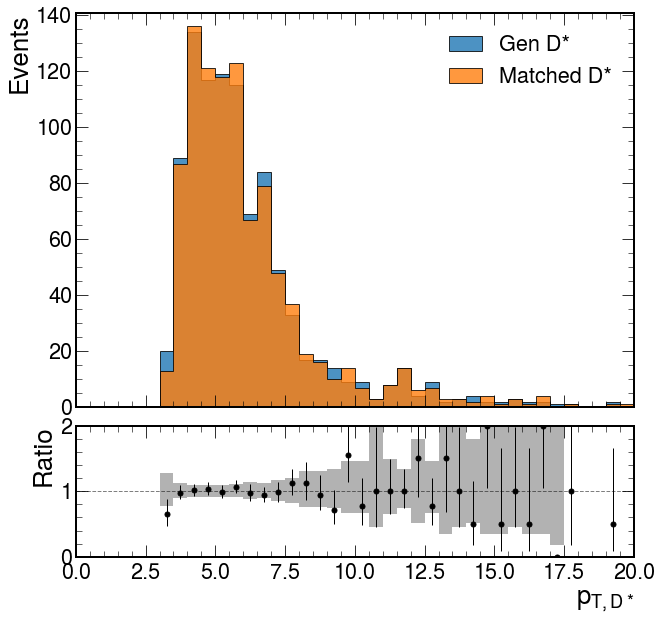

In [64]:
######################################## D* section ########################################

ax, rax = ratio_plot(output['matched_dstar_pt'], output['gen_dstar_pt'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen D*', 'Matched D*']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$p_{T,D*}$")

/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:435: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom ** 2) - rsumw
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:452: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom ** 2)


Text(1, 0, '$\\eta_{D*}$')

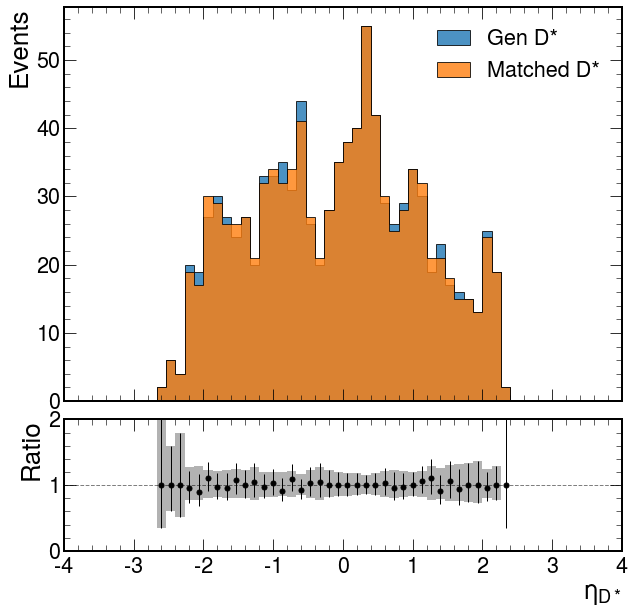

In [66]:
ax, rax = ratio_plot(output['matched_dstar_eta'], output['gen_dstar_eta'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen D*', 'Matched D*']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$\eta_{D*}$")

/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:435: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom ** 2) - rsumw
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:452: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom ** 2)


Text(1, 0, '$\\phi_{D*}$')

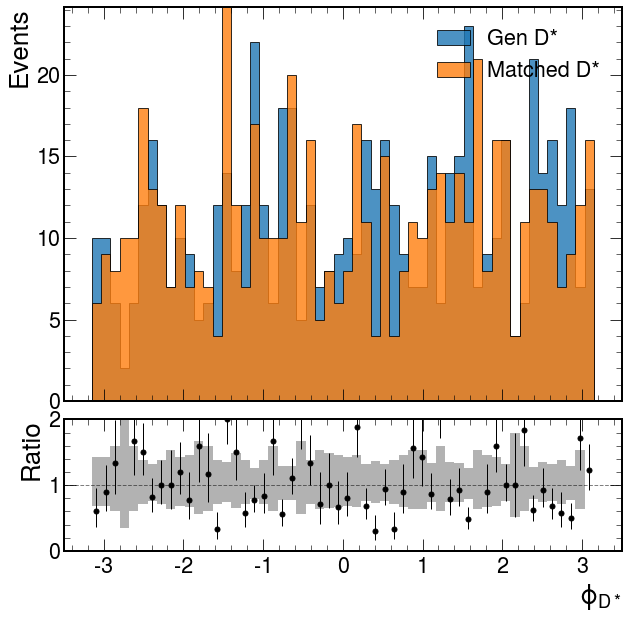

In [40]:
ax, rax = ratio_plot(output['matched_dstar_phi'], output['gen_dstar_phi'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen D*', 'Matched D*']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$\phi_{D*}$")

/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: divide by zero encountered in true_divide
  rsumw = sumw_num / sumw_denom
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:435: RuntimeWarning: divide by zero encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom ** 2) - rsumw
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:435: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom ** 2) - rsumw
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/

Text(1, 0, '$p_{T,D*}$')

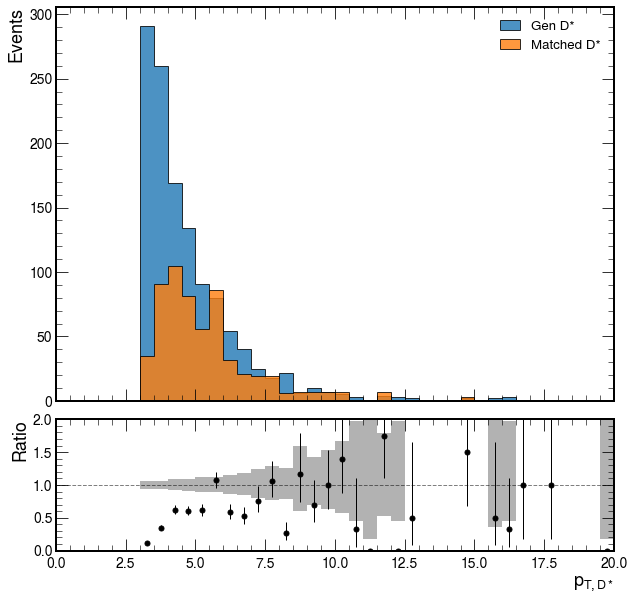

In [46]:
ax, rax = ratio_plot(output['matched_dstar_pt'], output['all_gen_dstar_pt'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen D*', 'Matched D*']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$p_{T,D*}$")

/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: divide by zero encountered in true_divide
  rsumw = sumw_num / sumw_denom
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:435: RuntimeWarning: divide by zero encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom ** 2) - rsumw
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:435: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom ** 2) - rsumw
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/

Text(1, 0, '$\\eta_{D*}$')

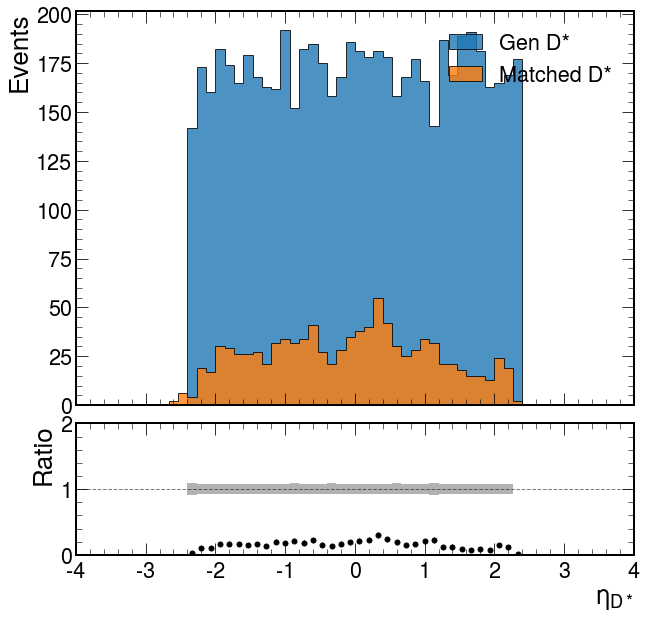

In [69]:
ax, rax = ratio_plot(output['matched_dstar_eta'], output['all_gen_dstar_eta'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen D*', 'Matched D*']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$\eta_{D*}$")

/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:435: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom ** 2) - rsumw
/afs/cern.ch/user/m/mabarros/miniconda3/envs/OniaOpenCharmRun2ULenv/lib/python3.8/site-packages/coffea/hist/plot.py:452: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom ** 2)


Text(1, 0, '$\\phi_{D*}$')

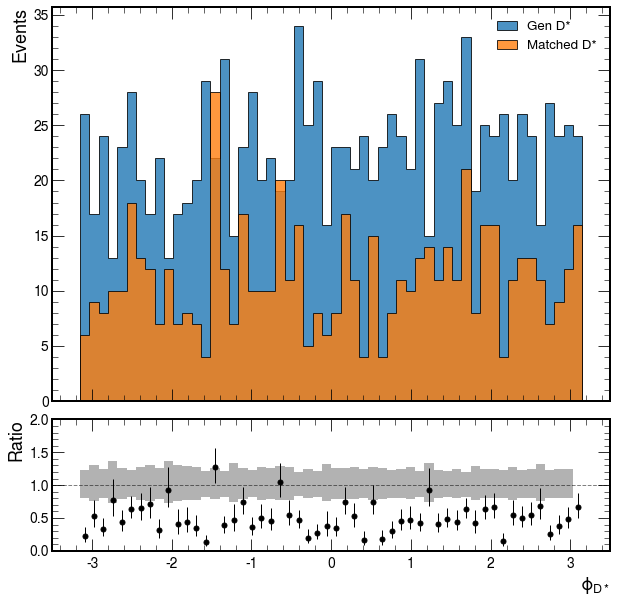

In [45]:
ax, rax = ratio_plot(output['matched_dstar_phi'], output['all_gen_dstar_phi'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Gen D*', 'Matched D*']

leg = ax.legend(handles, labels)
rax.set_xlabel(r"$\phi_{D*}$")

<AxesSubplot:xlabel='$\\Delta m_{D*}$ all', ylabel='Events'>

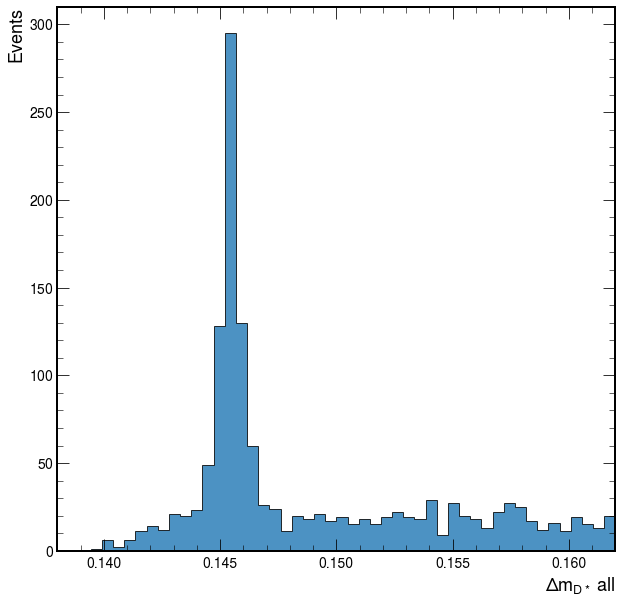

In [71]:
create_plot1d(output['all_dstar_deltamr'])

<AxesSubplot:xlabel='$\\Delta m_{D*}$ matched', ylabel='Events'>

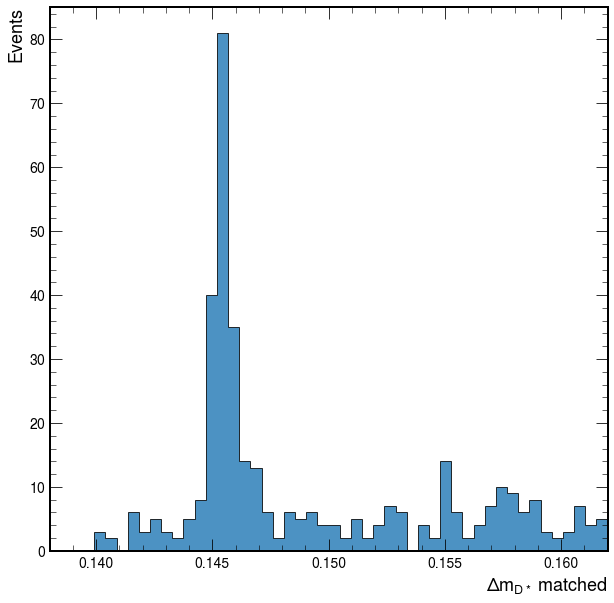

In [42]:
create_plot1d(output['matched_dstar_deltamr'])

<AxesSubplot:xlabel='$mass_{J/\\Psi} matched [GeV]$', ylabel='Events'>

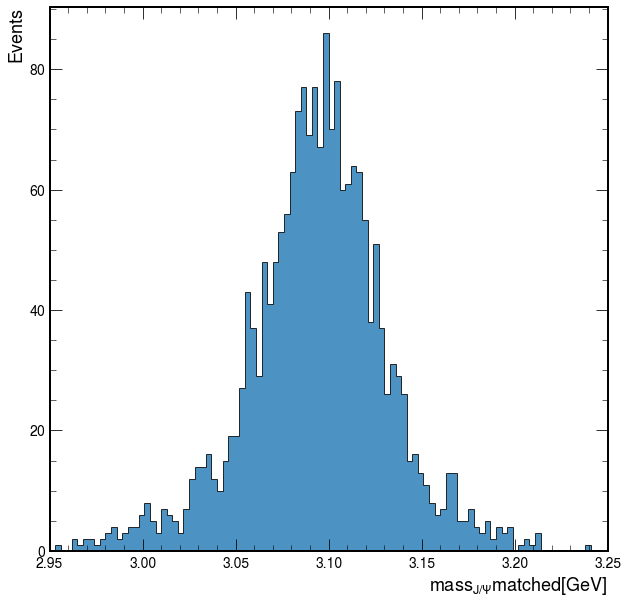

In [43]:
create_plot1d(output["matched_dimu_mass"])

<AxesSubplot:xlabel='$\\Delta m_{D*}$ matched', ylabel='Events'>

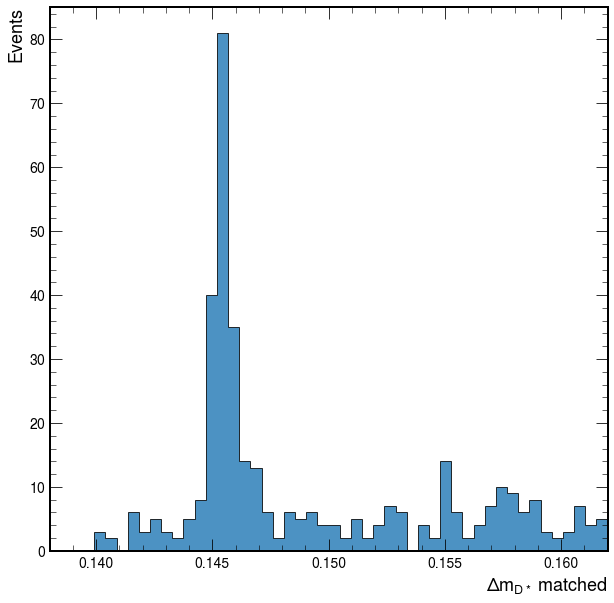

In [44]:
create_plot1d(output["matched_dstar_deltamr"])